**Step 3.a - Open Set Classification using Threshold.**

This code implements a text classification pipeline using BERT to identify music captions generated by different models, with an open-set recognition mechanism to detect unknown classes (e.g., "SunoCaps").
Here the classification boundary is defined by a threshold.

We have 6 known classes in the training while in the testing we add an unknown class (SunoCaps10s).

In [1]:
# Mount Google Drive in Google Colab.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Installing libraries needed for the project.
import os
import json
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [3]:
# Seed definition for reproducibility.
seed_val = 42
torch.manual_seed(seed_val)
random.seed(seed_val)
np.random.seed(seed_val)
print(f"Seed with value: {seed_val}")

# If possible use GPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

Seed with value: 42
Using Device: cuda


In [4]:
# Path that links to the folder with all the 6 classes + SunoCaps
base_dataset_path = "/content/drive/MyDrive/L02CapstoneProject/FakeMusicCapsCAPTIONS2500Tot"
print(f"Path of the dataset: {base_dataset_path}")

# éath where the Fine-tuned Model has been saved.
model_save_path = "/content/drive/MyDrive/L02CapstoneProject/BERT_output_model"
print(f"Path of the model: {model_save_path}")

Path of the dataset: /content/drive/MyDrive/L02CapstoneProject/FakeMusicCapsCAPTIONS2500Tot
Path of the model: /content/drive/MyDrive/L02CapstoneProject/BERT_output_model


In [10]:
# Loading function.

def load_data_from_folders(base_path, excluded_label=None):
    data = []
    print(f"Loading data from {base_path}...")

    # Check if the base_path itself contains JSON files
    is_base_folder_data = False
    try:
        files_in_base = [f for f in os.listdir(base_path) if f.endswith(".json")]
        if files_in_base:
            print(f"  Trovati {len(files_in_base)} file JSON direttamente in {base_path}.")
            # Use the basen folder name as the label for these files
            label = os.path.basename(base_path)
            if excluded_label and label == excluded_label:
                 print(f"  Except folder: {label}")
            else:
                is_base_folder_data = True
                for file in files_in_base:
                    file_path = os.path.join(base_path, file)
                    try:
                        with open(file_path, 'r') as f:
                            json_data = json.load(f)
                            # Assuming the structure is like {'0': {'text': 'caption text'}}
                            caption_data = json_data.get('0', {})
                            caption = caption_data.get("text", "")
                            if caption:
                                data.append({"text": caption, "label": label})
                    except Exception as e:
                        print(f"  Error reading {file_path}: {e}")
    except Exception as e:
        print(f"  Error reading in {base_path}: {e}")


    # If no JSON files were found directly in the base path, look into subfolders
    if not is_base_folder_data:
        for label_folder in os.listdir(base_path):
            if excluded_label and label_folder == excluded_label:
                print(f"  Esclusa cartella: {label_folder}")
                continue

            label_path = os.path.join(base_path, label_folder)
            if os.path.isdir(label_path):
                for file in os.listdir(label_path):
                    if file.endswith(".json"):
                        file_path = os.path.join(label_path, file)
                        try:
                            with open(file_path, 'r') as f:
                                json_data = json.load(f)
                                caption_data = json_data.get('0', {})
                                caption = caption_data.get("text", "")
                                if caption:
                                    data.append({"text": caption, "label": label_folder})
                        except Exception as e:
                            print(f"  Error reading {file_path}: {e}")

    print(f"Loading of the data completed. Number of elements equal to: {len(data)}")
    return pd.DataFrame(data)

In [11]:
# BERT tokenizer initialization.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
print("BERT tokenizer loaded: bert-base-uncased")

def tokenize_data(sentences, labels, max_len=128):
    input_ids = []
    attention_masks = []

    print(f"Tokenization of {len(sentences)} samples with max_len={max_len}...")
    for sent in sentences:
        encoded = tokenizer.encode_plus(
            sent,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)
    print("Tokenization completed.")
    return input_ids, attention_masks, labels

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

BERT tokenizer loaded: bert-base-uncased


In [12]:
# Load all the known classes.
df_known_classes = load_data_from_folders(base_dataset_path, excluded_label="SunoCaps10s")

# Create the original mapping label2id e id2label for the known classes.
known_labels_list = sorted(df_known_classes["label"].unique().tolist())
label2id_known = {label: idx for idx, label in enumerate(known_labels_list)}
id2label_known = {idx: label for label, idx in label2id_known.items()}
num_known_labels = len(known_labels_list)
print(f"\nKnown Classes and their mapping (ID): {label2id_known}")

# Load unknown class.
df_suno_caps = load_data_from_folders(os.path.join(base_dataset_path, "SunoCaps10s"))
df_suno_caps["label_text"] = df_suno_caps["label"]

# Give an ID to the unknown class.
unknown_class_id = num_known_labels
print(f"ID given to the unknown class (SunoCaps10s): {unknown_class_id}")

open_set_labels_list = known_labels_list + ["SunoCaps10s"]
label2id_open_set = {label: idx for idx, label in enumerate(open_set_labels_list)}
id2label_open_set = {idx: label for label, idx in label2id_open_set.items()}
print(f"\nExtended mapping for open-set (ID): {label2id_open_set}")

Loading data from /content/drive/MyDrive/L02CapstoneProject/FakeMusicCapsCAPTIONS2500Tot...
  Error reading /content/drive/MyDrive/L02CapstoneProject/FakeMusicCapsCAPTIONS2500Tot/MusicGen_medium/mWuX--EEq2E_captions.json: Expecting value: line 1 column 1 (char 0)
  Esclusa cartella: SunoCaps10s
Loading of the data completed. Number of elements equal to: 15029

Known Classes and their mapping (ID): {'MusicCaps': 0, 'MusicGen_medium': 1, 'audioldm2': 2, 'musicldm': 3, 'mustango': 4, 'stable_audio_open': 5}
Loading data from /content/drive/MyDrive/L02CapstoneProject/FakeMusicCapsCAPTIONS2500Tot/SunoCaps10s...
  Trovati 63 file JSON direttamente in /content/drive/MyDrive/L02CapstoneProject/FakeMusicCapsCAPTIONS2500Tot/SunoCaps10s.
Loading of the data completed. Number of elements equal to: 63
ID given to the unknown class (SunoCaps10s): 6

Extended mapping for open-set (ID): {'MusicCaps': 0, 'MusicGen_medium': 1, 'audioldm2': 2, 'musicldm': 3, 'mustango': 4, 'stable_audio_open': 5, 'SunoCa

In [13]:
from sklearn.model_selection import train_test_split
_, df_test_known_simulated = train_test_split(df_known_classes, test_size=0.5, stratify=df_known_classes["label"], random_state=42)

# Add the original string label column back to df_test_known_simulated.
df_test_known_simulated["label_text"] = df_test_known_simulated["label"]

df_test_known_simulated["label_encoded"] = df_test_known_simulated["label"].map(label2id_known)
df_test_known_simulated = df_test_known_simulated.drop(columns=['label'])


# Combine the test set of known classes with the unknown class.
# Ensure both dataframes have 'text' and 'label_text' columns before concatenation.
df_test_open_set = pd.concat([df_test_known_simulated[['text', 'label_text']], df_suno_caps[['text', 'label_text']]], ignore_index=True)

# Apply the extended mapping to create the final 'label' column for the open-set data.
df_test_open_set['label'] = df_test_open_set['label_text'].map(label2id_open_set)

# Tokenize the data.
if df_test_open_set['label'].isnull().any():
    print("Warning: NaN values found")


print(f"\nTest set Open-Set created with {len(df_test_open_set)} samples.")
print("Label distribution in Open-Set Test set:")
print(df_test_open_set['label_text'].value_counts())

# Tokenize the Open-Set test set
test_inputs_open_set, test_masks_open_set, test_labels_open_set = tokenize_data(
    df_test_open_set["text"].values, df_test_open_set["label"].values
)


Test set Open-Set created with 7578 samples.
Label distribution in Open-Set Test set:
label_text
stable_audio_open    1260
mustango             1255
audioldm2            1250
musicldm             1250
MusicGen_medium      1250
MusicCaps            1250
SunoCaps10s            63
Name: count, dtype: int64
Tokenization of 7578 samples with max_len=128...
Tokenization completed.


In [14]:
# Create the dataloader for the Open-set.
batch_size = 16
test_dataset_open_set = TensorDataset(test_inputs_open_set, test_masks_open_set, test_labels_open_set)
test_dataloader_open_set = DataLoader(
    test_dataset_open_set,
    sampler=SequentialSampler(test_dataset_open_set),
    batch_size=batch_size
)
print(f"DataLoader for the Open-set created with batch size ={batch_size}.")

DataLoader for the Open-set created with batch size =16.


In [15]:
# Loading of the fine-tuned BERT model.
model = BertForSequenceClassification.from_pretrained(
    model_save_path,
    num_labels=num_known_labels,
    output_attentions=False,
    output_hidden_states=False,
)
model.to(device)
model.eval()
print(f"\nBERT model loaded from the path: {model_save_path}. Number of training classes: {num_known_labels}.")


BERT model loaded from the path: /content/drive/MyDrive/L02CapstoneProject/BERT_output_model. Number of training classes: 6.


In [16]:
# Open-set with Threshold implementation.

def evaluate_open_set_threshold(model, dataloader, threshold, num_known_labels, device):
    model.eval()
    list_true_labels = []
    list_predicted_labels_closed_set = []
    list_max_probs = []

    print(f"\nStart evaluation with Threshold {threshold}...")
    for batch in dataloader:
        b_input_ids, b_input_mask, b_labels = [t.to(device) for t in batch]

        with torch.no_grad():
            outputs = model(b_input_ids, attention_mask=b_input_mask)

        logits = outputs.logits
        probs = F.softmax(logits, dim=-1) # Softmax to obtain probabilities

        max_probs_batch, predicted_class_ids_batch = torch.max(probs, dim=1)

        list_predicted_labels_closed_set.extend(predicted_class_ids_batch.cpu().numpy())
        list_true_labels.extend(b_labels.cpu().numpy())
        list_max_probs.extend(max_probs_batch.cpu().numpy())

    list_predicted_labels_open_set = []
    for i in range(len(list_predicted_labels_closed_set)):
        if list_max_probs[i] < threshold:
            # If max_prob is less than the threshold --> unknown.
            list_predicted_labels_open_set.append(num_known_labels) # unknown_class_id
        else:
            # Use Closed-set prediction.
            list_predicted_labels_open_set.append(list_predicted_labels_closed_set[i])
    print("Valutazione Open-Set completata.")
    return list_true_labels, list_predicted_labels_open_set



In [17]:
import os
import json

suno_caps_path = "/content/drive/MyDrive/L02CapstoneProject/FakeMusicCapsCAPTIONS2500Tot/SunoCaps10s"
print(f"Inspecting files in: {suno_caps_path}")

# List files in the directory
try:
    files_in_folder = [f for f in os.listdir(suno_caps_path) if f.endswith(".json")]
    print(f"Found {len(files_in_folder)} JSON files.")

    # Inspect the first few files (or all if less than 5)
    files_to_inspect = files_in_folder[:5] if len(files_in_folder) > 5 else files_in_folder

    if files_to_inspect:
        print("\nInspecting content of the first few JSON files:")
        for file_name in files_to_inspect:
            file_path = os.path.join(suno_caps_path, file_name)
            print(f"\n--- Content of {file_name} ---")
            try:
                with open(file_path, 'r') as f:
                    content = json.load(f)
                    print(json.dumps(content, indent=2)) # Print formatted JSON content
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON in {file_name}: {e}")
            except Exception as e:
                print(f"Error reading {file_name}: {e}")
    else:
        print("\nNo JSON files found in the folder to inspect.")

except FileNotFoundError:
    print(f"Error: The directory was not found: {suno_caps_path}")
except Exception as e:
    print(f"An error occurred while listing files: {e}")

Inspecting files in: /content/drive/MyDrive/L02CapstoneProject/FakeMusicCapsCAPTIONS2500Tot/SunoCaps10s
Found 63 JSON files.

Inspecting content of the first few JSON files:

--- Content of 0dPx94RPy2M_captions.json ---
{
  "0": {
    "text": "This hard rock song feels like the kind of song that would play as you are preparing to go to war. The instruments are gritty, grungy, and intense. The electric guitarist plays an intricate motif and the bass player matches the main part of the riff. The drummer plays potent and punchy rhythms which feature the crash cymbal - which adds a bright shimmery contrast to the dark and grungry guitars.",
    "time": "0:00-10:00"
  }
}

--- Content of 2Ic1zm9mBjk_captions.json ---
{
  "0": {
    "text": "The low quality recording features a flat male vocal, alongside harmonizing background vocals, singing over sustained strings melody, punchy kick and snare hits, shimmering cymbals, groovy bass and synth pad chords. It sounds emotional, passionate and jo


Threshold imposed with value: 0.75

Start evaluation with Threshold 0.75...
Valutazione Open-Set completata.

Label name: ['MusicCaps', 'MusicGen_medium', 'audioldm2', 'musicldm', 'mustango', 'stable_audio_open', 'SunoCaps10s']

Confusion Matrix:
[[ 39  43  45 605  98  34 386]
 [ 30 649  44  16  32  53 426]
 [ 48  50  20  20  29 695 388]
 [584  48  23  16  54  84 441]
 [ 36  28  39  40 726  37 349]
 [ 21  61 800  23  38  26 291]
 [  3   4  10   8   6   2  30]]

Normalized Confusion Matrix:
[[0.0312     0.0344     0.036      0.484      0.0784     0.0272
  0.3088    ]
 [0.024      0.5192     0.0352     0.0128     0.0256     0.0424
  0.3408    ]
 [0.0384     0.04       0.016      0.016      0.0232     0.556
  0.3104    ]
 [0.4672     0.0384     0.0184     0.0128     0.0432     0.0672
  0.3528    ]
 [0.02868526 0.02231076 0.0310757  0.03187251 0.57848606 0.02948207
  0.27808765]
 [0.01666667 0.0484127  0.63492063 0.01825397 0.03015873 0.02063492
  0.23095238]
 [0.04761905 0.06349206 0.158

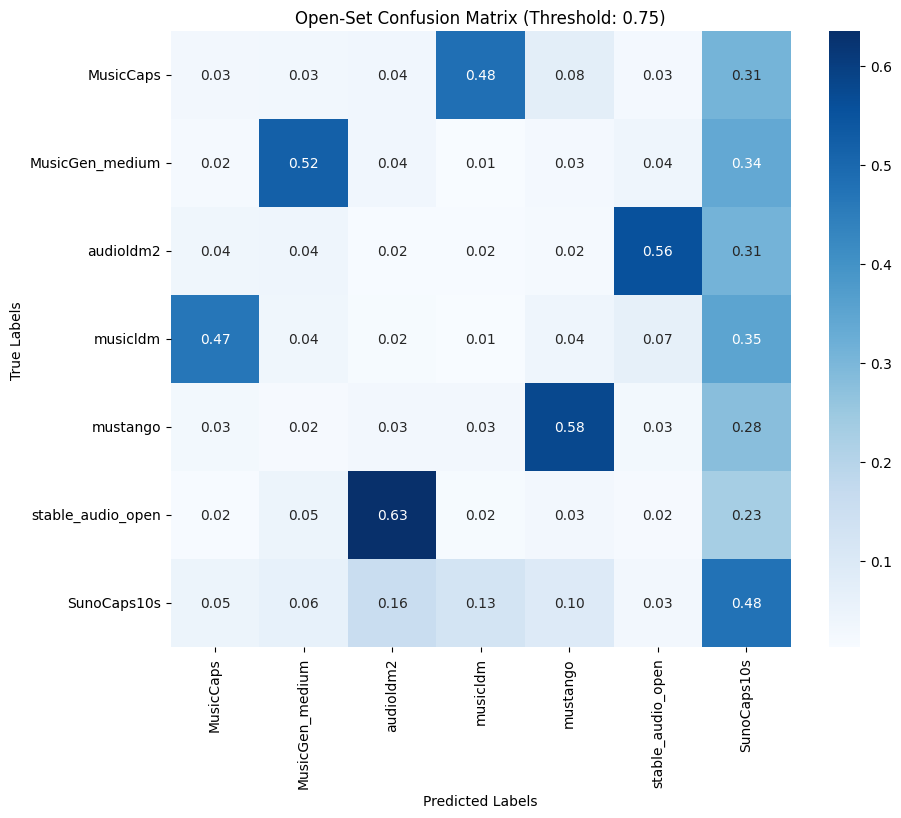


📋 Open-Set Classification Report (Threshold):
                    precision    recall  f1-score   support

        MusicCaps       0.05      0.03      0.04      1250
  MusicGen_medium       0.73      0.52      0.61      1250
        audioldm2       0.02      0.02      0.02      1250
         musicldm       0.02      0.01      0.02      1250
         mustango       0.74      0.58      0.65      1255
stable_audio_open       0.03      0.02      0.02      1260
      SunoCaps10s       0.01      0.48      0.03        63

         accuracy                           0.20      7578
        macro avg       0.23      0.24      0.20      7578
     weighted avg       0.26      0.20      0.22      7578


--- Evaluation Completed ---


In [21]:
# Evaluation.
threshold_value = 0.75
print(f"\nThreshold imposed with value: {threshold_value}")

true_labels_os_threshold, predicted_labels_os_threshold = evaluate_open_set_threshold(
    model, test_dataloader_open_set, threshold_value, unknown_class_id, device
)

# Results.
open_set_labels_display_names = [id2label_open_set[i] for i in sorted(id2label_open_set.keys())]
print(f"\nLabel name: {open_set_labels_display_names}")

# Confusion Matrix.
cm_os_threshold = confusion_matrix(
    true_labels_os_threshold,
    predicted_labels_os_threshold,
    labels=[i for i in sorted(id2label_open_set.keys())]
)
print("\nConfusion Matrix:")
print(cm_os_threshold)

# Confusion Matrix normalization.
cm_os_threshold_normalized = cm_os_threshold.astype('float') / cm_os_threshold.sum(axis=1)[:, np.newaxis]
print("\nNormalized Confusion Matrix:")
print(cm_os_threshold_normalized)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_os_threshold_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=open_set_labels_display_names,
            yticklabels=open_set_labels_display_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Open-Set Confusion Matrix (Threshold: {threshold_value})')
plt.show()

# Classification report.
print("\n📋 Open-Set Classification Report (Threshold):\n",
      classification_report(true_labels_os_threshold, predicted_labels_os_threshold,
                            target_names=open_set_labels_display_names, zero_division=0))

print("\n--- Evaluation Completed ---")